<a href="https://colab.research.google.com/github/jaysmerrill/Yaquina_Bay_Seiching/blob/main/seiche_prediction_20250930.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== Horizon 60 min ===
windows: train=60000  val=60000  test=25282
[TCN] epoch 01  trainMSE=23.91459  valMSE=0.07570
[TCN] epoch 02  trainMSE=0.08084  valMSE=0.06015
[TCN] epoch 03  trainMSE=0.06069  valMSE=0.04999
[TCN] epoch 04  trainMSE=0.05474  valMSE=0.04604
[TCN] epoch 05  trainMSE=0.05940  valMSE=0.04491
[TCN] epoch 06  trainMSE=0.05252  valMSE=0.04344
TFT not available or failed; using lightweight Transformer. Err: TimeSeriesDataSet.__init__() got an unexpected keyword argument 'time_varying_unknown_past'
[Transformer] epoch 01 valMSE=0.04301
[Transformer] epoch 02 valMSE=0.05945
[Transformer] epoch 03 valMSE=0.04693
[Transformer] epoch 04 valMSE=0.06395
[Transformer] early stop.
TCN  @ 60m: R²=0.069  RMSE=0.744
Transformer @ 60m: R²=-0.771  RMSE=1.026

=== Horizon 120 min ===
windows: train=60000  val=60000  test=25282
[TCN] epoch 01  trainMSE=2.08423  valMSE=0.07580
[TCN] epoch 02  trainMSE=0.09709  valMSE=0.05948
[TCN] epoch 03  trainMSE=0.06373  valMSE=0.07148
[TCN] epoch 

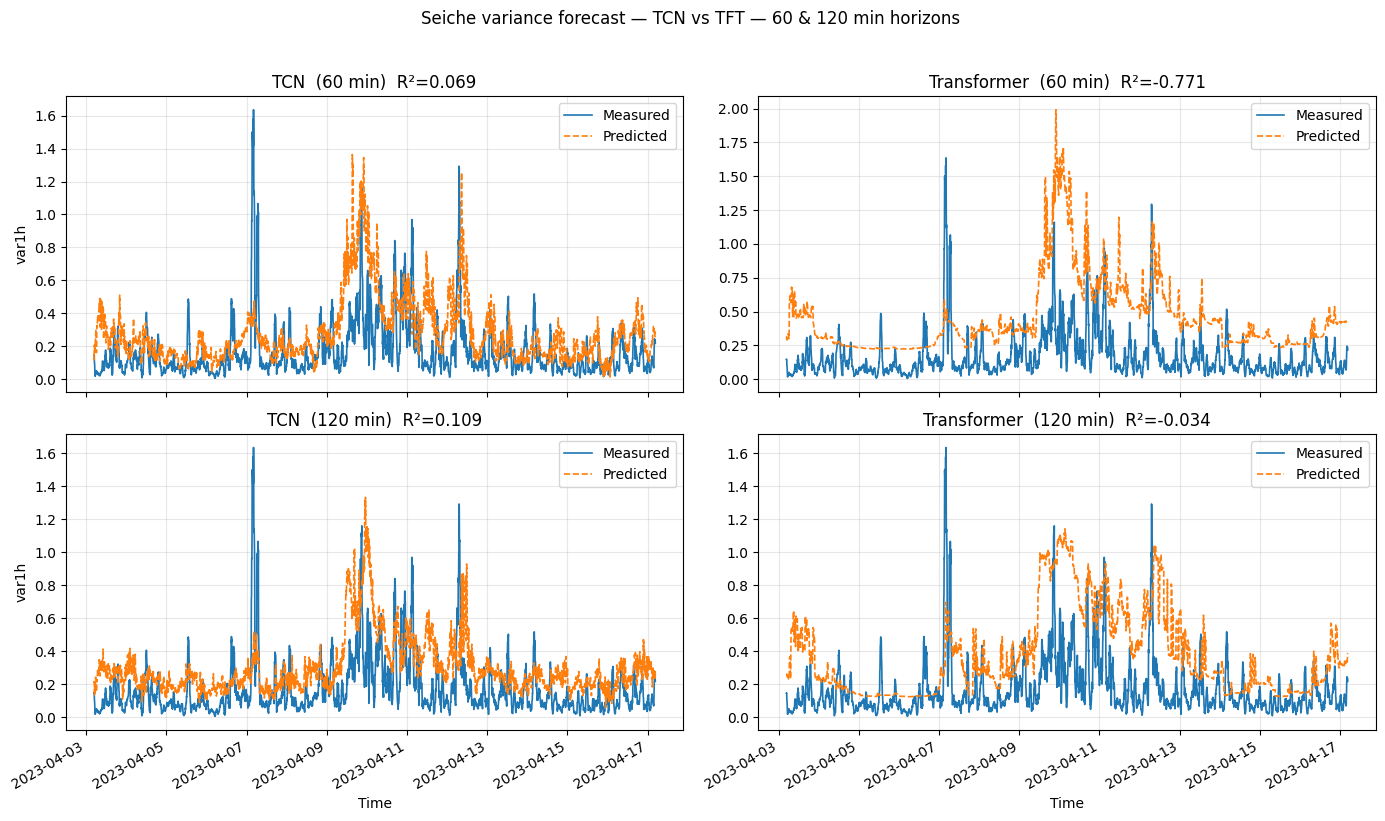

In [7]:
# =========================
# MEMORY-LITE, DUAL-HORIZON TCN vs TFT (stride=1, epochs=6, AMP updated)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score

# ----- USER KNOBS -----
DT_MINUTES       = 6
HISTORY_HOURS    = 12              # reduce to 8 if you still hit RAM limits
HORIZONS_MIN     = [60, 120]       # predict 1h and 2h ahead
BATCH_SIZE       = 256
EPOCHS_TCN       = 6
EPOCHS_TFT       = 6
LEARNING_RATE    = 2e-3
DROPOUT          = 0.2
MAX_SAMPLES_PER_SPLIT = 60_000     # cap per split to control RAM
PLOT_DAYS        = 14

# Time splits consistent with earlier code
TRAIN_END = pd.Timestamp("2018-12-31 23:59:59")
VAL_END   = pd.Timestamp("2022-12-31 23:59:59")

# ---------- Prepare numeric matrix ----------
df_seq = df_seq.copy()
df_seq["time"] = pd.to_datetime(df_seq["time"])
df_seq = df_seq.sort_values("time").reset_index(drop=True)

# Downcast to float32 to save RAM
for c in df_seq.columns:
    if c != "time":
        df_seq[c] = pd.to_numeric(df_seq[c], errors="coerce").astype("float32")

target_col = "var1h"
assert target_col in df_seq.columns

feature_cols = [c for c in df_seq.columns if c not in ["time", "var1h_log1p"]]
feature_cols_no_target = [c for c in feature_cols if c != target_col]

A = df_seq[feature_cols_no_target].to_numpy(dtype=np.float32)   # (T, F)
y_full = df_seq[target_col].to_numpy(dtype=np.float32)          # (T,)
t_full = pd.to_datetime(df_seq["time"]).to_numpy()
F = A.shape[1]
steps_hist = int(round(HISTORY_HOURS * 60 / DT_MINUTES))

def build_windows_indices(horizon_min: int):
    steps_ahead = int(round(horizon_min / DT_MINUTES))
    idx_list = []
    Ttot = len(df_seq)
    # stride = 1 to preserve 6-min granularity (captures short seiche events)
    for end_idx in range(steps_hist, Ttot - steps_ahead + 1, 1):
        s = end_idx - steps_hist
        e = end_idx
        k = end_idx - 1 + steps_ahead
        if not np.isfinite(y_full[k]):            # target valid
            continue
        block = A[s:e]
        if np.any(~np.isfinite(block)):           # features valid
            continue
        idx_list.append((s, e, k))
    # time for each sample = target time
    t_y = pd.DatetimeIndex(t_full[[k for _,_,k in idx_list]])
    # splits by time
    tr_mask = t_y <= TRAIN_END
    va_mask = (t_y > TRAIN_END) & (t_y <= VAL_END)
    te_mask = t_y > VAL_END
    def select(mask):
        sel = [tpl for tpl, m in zip(idx_list, mask) if m]
        if len(sel) > MAX_SAMPLES_PER_SPLIT:
            pick = np.linspace(0, len(sel)-1, MAX_SAMPLES_PER_SPLIT, dtype=int)
            sel = [sel[i] for i in pick]
        return sel
    idx_tr, idx_va, idx_te = select(tr_mask), select(va_mask), select(te_mask)
    t_test = pd.DatetimeIndex(t_full[[k for _,_,k in idx_te]])
    return idx_tr, idx_va, idx_te, t_test

# Robust scaler fit on TRAIN windows (sampled rows)
def fit_scaler_from_windows(A, windows):
    if not windows:
        rs = RobustScaler()
        rs.fit(A[:1000])
        return rs
    # sample up to ~1e6 rows
    budget = 1_000_000
    rows = []
    take_per = max(1, budget // max(1, len(windows)))
    for s,e,_ in windows:
        seg = A[s:e]
        rows.append(seg[:min(len(seg), take_per)])
    Xs = np.vstack(rows) if rows else A[:1000]
    rs = RobustScaler()
    rs.fit(Xs)
    return rs

# --- RMSE helper (no sklearn version issues) ---
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

# Torch bits (AMP updated API)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from contextlib import nullcontext

use_gpu = torch.cuda.is_available()
if use_gpu:
    torch.backends.cudnn.benchmark = True
    if hasattr(torch, "set_float32_matmul_precision"):
        torch.set_float32_matmul_precision("high")

# --- AMP compatibility: works across torch versions (torch.amp vs torch.cuda.amp) ---
from contextlib import nullcontext

def _make_amp(use_gpu: bool):
    if not use_gpu:
        return nullcontext, None  # CPU: no AMP
    # Try the newer torch.amp API first
    try:
        import torch.amp as _amp
        def _ctx():
            return _amp.autocast(device_type="cuda", enabled=True)
        try:
            scaler = _amp.GradScaler(enabled=True)   # some versions accept only 'enabled'
        except TypeError:
            scaler = _amp.GradScaler()               # fallback: no args
        return _ctx, scaler
    except Exception:
        # Fallback to legacy torch.cuda.amp
        from torch.cuda.amp import autocast as _autocast, GradScaler as _GradScaler
        def _ctx():
            return _autocast(enabled=True)
        scaler = _GradScaler(enabled=True)
        return _ctx, scaler

amp_ctx_fn, scaler = _make_amp(use_gpu)
def amp_ctx():
    return amp_ctx_fn()

class WindowedDataset(Dataset):
    def __init__(self, A, y, windows, scaler: RobustScaler, log_target=True):
        self.A = A; self.y = y; self.windows = windows; self.scaler = scaler
        self.log_target = log_target
    def __len__(self): return len(self.windows)
    def __getitem__(self, i):
        s,e,k = self.windows[i]
        x = self.scaler.transform(self.A[s:e])
        x = torch.from_numpy(x.astype(np.float32))     # (T,F)
        yy = float(self.y[k])
        if self.log_target: yy = np.log1p(max(0.0, yy))
        y_t = torch.tensor(yy, dtype=torch.float32)
        return x, y_t

# TCN model
class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding, dilation=dilation),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding, dilation=dilation),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        for m in self.modules():
            if isinstance(m, nn.Conv1d): nn.init.kaiming_normal_(m.weight)
    def forward(self, x):
        y = self.net(x)
        crop = y.size(-1) - x.size(-1)
        if crop > 0: y = y[:, :, :-crop]
        return torch.relu(y + self.down(x))

class TCN(nn.Module):
    def __init__(self, in_ch, channels=(128,128,128), k=5, drop=0.2):
        super().__init__()
        layers = []; cprev = in_ch
        for i,c in enumerate(channels):
            layers.append(TemporalBlock(cprev, c, k, dilation=2**i, dropout=drop))
            cprev = c
        self.tcn = nn.Sequential(*layers)
        self.head = nn.Linear(cprev, 1)
    def forward(self, x):           # x: (B,T,F)
        x = x.transpose(1,2)        # (B,F,T)
        y = self.tcn(x)             # (B,C,T)
        last = y[:, :, -1]          # (B,C)
        return self.head(last).squeeze(-1)  # (B,)

def train_tcn(train_dl, val_dl, in_ch):
    device = torch.device("cuda" if use_gpu else "cpu")
    model = TCN(in_ch=in_ch, channels=(128,128,128), k=5, drop=DROPOUT).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()
    best_val = float("inf"); best_state=None; patience=3; bad=0
    for ep in range(EPOCHS_TCN):
        model.train(); tr=0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            with amp_ctx():
                pred = model(xb)
                loss = loss_fn(pred, yb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            tr += loss.item()*len(xb)
        tr/=max(1,len(train_dl.dataset))
        # val
        model.eval(); va=0.0
        with torch.no_grad(), amp_ctx():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                va += loss_fn(model(xb), yb).item()*len(xb)
        va/=max(1,len(val_dl.dataset))
        print(f"[TCN] epoch {ep+1:02d}  trainMSE={tr:.5f}  valMSE={va:.5f}")
        if va + 1e-6 < best_val:
            best_val = va; best_state = model.state_dict(); bad=0
        else:
            bad += 1
            if bad >= patience: print("[TCN] early stop."); break
    if best_state is not None: model.load_state_dict(best_state)
    return model

def predict_tcn(model, dataset, batch=512):
    device = next(model.parameters()).device
    model.eval(); preds=[]
    with torch.no_grad(), amp_ctx():
        for i in range(0, len(dataset), batch):
            xb = [dataset[j][0].numpy() for j in range(i, min(i+batch, len(dataset)))]
            xb = torch.from_numpy(np.stack(xb)).to(device)
            yb = model(xb).cpu().numpy()
            preds.append(yb)
    y_log = np.concatenate(preds)
    return np.expm1(y_log)   # back to original scale

# Try TFT (pytorch-forecasting). If not available, use lightweight Transformer.
def train_predict_tft_fallback(df_seq, feature_cols_no_target, target_col,
                               history_hours, horizon_min,
                               batch_size=BATCH_SIZE, epochs=EPOCHS_TFT):
    # Attempt TFT
    try:
        import pytorch_lightning as pl
        from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
        from pytorch_forecasting.metrics import QuantileLoss

        dfp = df_seq.copy()
        dfp["time_idx"] = ((dfp["time"] - dfp["time"].min())/pd.Timedelta(minutes=DT_MINUTES)).astype(int)
        dfp["series"] = 0
        max_encoder_length = int(round(history_hours*60/DT_MINUTES))
        max_prediction_length = int(round(horizon_min/DT_MINUTES))

        dfp["target_log1p"] = np.log1p(np.clip(dfp[target_col].values, 0, None))

        known_future = [c for c in ["hod_sin","hod_cos","doy_sin","doy_cos"] if c in dfp.columns]
        observed_past = [c for c in feature_cols_no_target if c not in known_future]

        training = TimeSeriesDataSet(
            dfp,
            time_idx="time_idx",
            target="target_log1p",
            group_ids=["series"],
            max_encoder_length=max_encoder_length,
            max_prediction_length=max_prediction_length,
            time_varying_unknown_past=observed_past + [target_col],
            time_varying_known_past=known_future,
            time_varying_known_future=known_future,
            add_relative_time_idx=True,
            add_encoder_length=True,
            add_target_scales=False,
        )
        train_mask = dfp["time"] <= TRAIN_END
        val_mask   = (dfp["time"] > TRAIN_END) & (dfp["time"] <= VAL_END)
        test_mask  = dfp["time"] > VAL_END

        train_ds = training.from_parameters(training.get_parameters(), dfp.loc[train_mask])
        val_ds   = training.from_parameters(training.get_parameters(), dfp.loc[val_mask])
        test_ds  = training.from_parameters(training.get_parameters(), dfp.loc[test_mask])

        train_dl = train_ds.to_dataloader(train=True, batch_size=min(batch_size, 512))
        val_dl   = val_ds.to_dataloader(train=False, batch_size=min(batch_size, 512))
        test_dl  = test_ds.to_dataloader(train=False, batch_size=min(batch_size, 512))

        trainer = pl.Trainer(max_epochs=epochs, accelerator="auto",
                             precision="16-mixed", enable_checkpointing=False, logger=False)
        tft = TemporalFusionTransformer.from_dataset(
            training,
            learning_rate=LEARNING_RATE,
            hidden_size=64,
            attention_head_size=4,
            dropout=DROPOUT,
            loss=QuantileLoss(),
            reduce_on_plateau_patience=2,
        )
        trainer.fit(tft, train_dl, val_dl)
        preds, _ = tft.predict(test_dl, return_x=True, mode="prediction")
        if preds.ndim == 3: preds = preds[:, :, -1]
        elif preds.ndim == 2: preds = preds[:, -1]
        y_pred = np.expm1(preds.cpu().numpy())
        return y_pred, True
    except Exception as e:
        print("TFT not available or failed; using lightweight Transformer. Err:", e)
        # Fallback transformer
        import torch
        class TransformerReg(nn.Module):
            def __init__(self, d_in, d_model=128, nhead=4, layers=3, drop=0.2):
                super().__init__()
                self.proj = nn.Linear(d_in, d_model)
                enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=drop, batch_first=True)
                self.enc = nn.TransformerEncoder(enc_layer, num_layers=layers)
                self.head = nn.Sequential(nn.Linear(d_model, d_model//2), nn.ReLU(), nn.Linear(d_model//2,1))
            def forward(self, x):
                z = self.proj(x)
                z = self.enc(z)
                return self.head(z[:,-1,:]).squeeze(-1)

        device = torch.device("cuda" if use_gpu else "cpu")
        # Rebuild indices for this horizon and a scaler
        idx_tr, idx_va, idx_te, t_test_h = build_windows_indices(horizon_min)
        rs = fit_scaler_from_windows(A, idx_tr)
        train_ds = WindowedDataset(A, y_full, idx_tr, rs, log_target=True)
        val_ds   = WindowedDataset(A, y_full, idx_va, rs, log_target=True)
        test_ds  = WindowedDataset(A, y_full, idx_te, rs, log_target=False)

        train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
        val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

        model = TransformerReg(F, d_model=128, nhead=4, layers=3, drop=DROPOUT).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        loss_fn = nn.MSELoss()
        best_val=float("inf"); best_state=None; bad=0; patience=3
        for ep in range(EPOCHS_TFT):
            model.train(); tr=0.0
            for xb,yb in train_dl:
                xb,yb = xb.to(device), yb.to(device)
                opt.zero_grad(set_to_none=True)
                with amp_ctx():
                    pred = model(xb); loss = loss_fn(pred, yb)
                scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
                tr += loss.item()*len(xb)
            model.eval(); va=0.0
            with torch.no_grad(), amp_ctx():
                for xb,yb in val_dl:
                    xb,yb = xb.to(device), yb.to(device)
                    va += loss_fn(model(xb), yb).item()*len(xb)
            va/=max(1,len(val_dl.dataset))
            print(f"[Transformer] epoch {ep+1:02d} valMSE={va:.5f}")
            if va + 1e-6 < best_val: best_val=va; best_state=model.state_dict(); bad=0
            else:
                bad+=1
                if bad>=3: print("[Transformer] early stop."); break
        if best_state is not None: model.load_state_dict(best_state)

        # predict
        model.eval(); preds=[]
        with torch.no_grad(), amp_ctx():
            for i in range(0, len(test_ds), 512):
                xb = [test_ds[j][0].numpy() for j in range(i, min(i+512, len(test_ds)))]
                xb = torch.from_numpy(np.stack(xb)).to(device)
                yp = model(xb).cpu().numpy()
                preds.append(yp)
        y_pred_log = np.concatenate(preds)
        y_pred = np.expm1(y_pred_log)
        return y_pred, False

# ---------- Train/eval both horizons ----------
results = {}

for horizon_min in HORIZONS_MIN:
    print(f"\n=== Horizon {horizon_min} min ===")
    # indices + scaler
    idx_tr, idx_va, idx_te, t_test = build_windows_indices(horizon_min)
    print(f"windows: train={len(idx_tr)}  val={len(idx_va)}  test={len(idx_te)}")
    rs = fit_scaler_from_windows(A, idx_tr)

    # datasets/loaders
    train_ds = WindowedDataset(A, y_full, idx_tr, rs, log_target=True)
    val_ds   = WindowedDataset(A, y_full, idx_va, rs, log_target=True)
    test_ds  = WindowedDataset(A, y_full, idx_te, rs, log_target=False)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=False)
    val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, drop_last=False)

    # --- TCN ---
    tcn = train_tcn(train_dl, val_dl, in_ch=F)
    y_pred_tcn = predict_tcn(tcn, test_ds, batch=512)
    y_test = y_full[[k for _,_,k in idx_te]]
    r2_tcn = r2_score(y_test, y_pred_tcn)
    rmse_tcn = rmse(y_test, y_pred_tcn)

    # --- TFT / Transformer ---
    y_pred_tft, is_tft = train_predict_tft_fallback(df_seq, feature_cols_no_target, target_col,
                                                    HISTORY_HOURS, horizon_min,
                                                    batch_size=BATCH_SIZE, epochs=EPOCHS_TFT)
    # align lengths by tail
    if len(y_pred_tft) > len(y_test):
        y_pred_tft = y_pred_tft[-len(y_test):]
    elif len(y_pred_tft) < len(y_test):
        y_test = y_test[-len(y_pred_tft):]
        t_test = t_test[-len(y_pred_tft):]
    r2_tft = r2_score(y_test, y_pred_tft)
    rmse_tft = rmse(y_test, y_pred_tft)

    results[horizon_min] = {
        "t_test": t_test, "y_test": y_test,
        "tcn_pred": y_pred_tcn, "tft_pred": y_pred_tft,
        "r2_tcn": r2_tcn, "rmse_tcn": rmse_tcn,
        "r2_tft": r2_tft, "rmse_tft": rmse_tft,
        "is_tft": is_tft,
    }
    print(f"TCN  @ {horizon_min}m: R²={r2_tcn:.3f}  RMSE={rmse_tcn:.3f}")
    print(f"{'TFT' if is_tft else 'Transformer'} @ {horizon_min}m: R²={r2_tft:.3f}  RMSE={rmse_tft:.3f}")

# ---------- Plot 2×2: rows=horizons (60m, 120m), cols=models (TCN, TFT) ----------
fig, axes = plt.subplots(len(HORIZONS_MIN), 2, figsize=(14, 4*len(HORIZONS_MIN)), sharex=False)
if len(HORIZONS_MIN)==1:
    axes = np.array([axes])  # ensure 2D
for r, horizon_min in enumerate(HORIZONS_MIN):
    res = results[horizon_min]
    ts = res["t_test"]; yt = res["y_test"]
    span = min(len(ts), int(PLOT_DAYS*24*60/DT_MINUTES))  # last PLOT_DAYS days
    ts = ts[-span:]; yt = yt[-span:]
    yp_tcn = res["tcn_pred"][-span:]
    yp_tft = res["tft_pred"][-span:]

    ax0 = axes[r,0]; ax1 = axes[r,1]
    ax0.plot(ts, yt, label="Measured", linewidth=1.2)
    ax0.plot(ts, yp_tcn, "--", label="Predicted", linewidth=1.2)
    ax0.set_title(f"TCN  ({horizon_min} min)  R²={res['r2_tcn']:.3f}")
    ax0.set_ylabel("var1h"); ax0.grid(alpha=0.3); ax0.legend()

    ax1.plot(ts, yt, label="Measured", linewidth=1.2)
    ax1.plot(ts, yp_tft, "--", label="Predicted", linewidth=1.2)
    name = "TFT" if res["is_tft"] else "Transformer"
    ax1.set_title(f"{name}  ({horizon_min} min)  R²={res['r2_tft']:.3f}")
    ax1.grid(alpha=0.3); ax1.legend()
    ax0.set_xlabel("Time"); ax1.set_xlabel("Time")

fig.suptitle("Seiche variance forecast — TCN vs TFT — 60 & 120 min horizons", y=1.02)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
